# Ampere verification notebook 

This notebook loads the results stored in `ampere_test.h5` and compares the
numerical current density components (Jx, Jy, Jz) with the analytical
expectations for the 1D Ampère test.

### Magnetic field configuration
- Bx = 0  
- By = cos(x)  
- Bz = sin(x)

### Analytical expectations (∇×B = J, normalized units)
In 1D, the curl reduces to:
- Jx = 0  
- Jy = - dBz/dx = -cos(x)  
- Jz = + dBy/dx = -sin(x)

### Grid staggering
- `xprimal`: locations of primal quantities (Jy, Jz)  
- `xdual`: locations of dual quantities (Jx)

The goal of this test is to verify the correct implementation of the discrete
curl operator, the consistency of grid staggering (primal/dual grids), and the
overall accuracy of the numerical scheme.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

H5_PATH = "../../../build-IRT/ampere_test.h5"

with h5py.File(H5_PATH, "r") as f:
    print("Keys in file:", list(f.keys()))

Keys in file: ['Bx', 'By', 'Bz', 'Jx', 'Jy', 'Jz', 'xdual', 'xprimal']


In [2]:
with h5py.File(H5_PATH, "r") as f:
    xprimal = f["xprimal"][:]
    xdual   = f["xdual"][:]
    Bx      = f["Bx"][:]
    By      = f["By"][:]
    Bz      = f["Bz"][:]
    Jx      = f["Jx"][:]
    Jy      = f["Jy"][:]
    Jz      = f["Jz"][:]

print("Shapes:")
print(" xprimal:", xprimal.shape, "xdual:", xdual.shape)
print(" By:", By.shape, "Bz:", Bz.shape)
print(" Jy:", Jy.shape, "Jz:", Jz.shape, "Jx:", Jx.shape)


Shapes:
 xprimal: (1001,) xdual: (1002,)
 By: (1002,) Bz: (1002,)
 Jy: (1001,) Jz: (1001,) Jx: (1000,)


In [3]:
# Building analytic reference curves
# B_y(x)=cos(x), B_z(x) = sin(x),
# J_y(x) = -cos(x), J_z(x) = -sin(x)

Jy_exact = -np.cos(xprimal)
Jz_exact = -np.sin(xprimal)

max_err_Jy = np.max(np.abs(Jy - Jy_exact))
max_err_Jz = np.max(np.abs(Jz - Jz_exact))

print("Max |Jy - Jy_exact| =", max_err_Jy)
print("Max |Jz - Jz_exact| =", max_err_Jz)

Max |Jy - Jy_exact| = 1.0
Max |Jz - Jz_exact| = 0.00041661312431695574


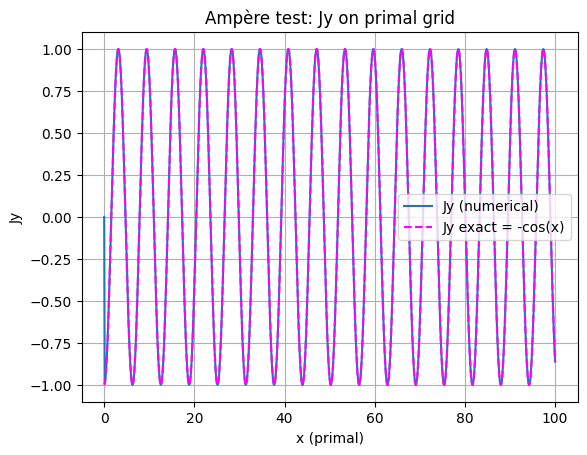

In [4]:
# Plot J_y vs analytic reference

plt.figure()
plt.plot(xprimal, Jy, label="Jy (numerical)")
plt.plot(xprimal, Jy_exact, "--", label="Jy exact = -cos(x)", color='magenta')
plt.xlabel("x (primal)")
plt.ylabel("Jy")
plt.title("Ampère test: Jy on primal grid")
plt.grid(True)
plt.legend()
plt.show()

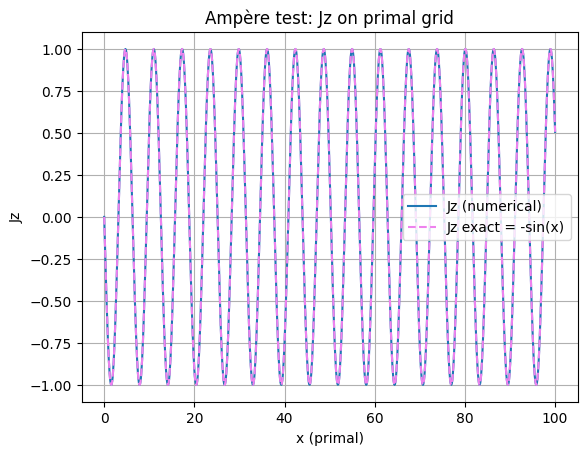

In [5]:
# Plot J_z vs analytic reference

plt.figure()
plt.plot(xprimal, Jz, label="Jz (numerical)")
plt.plot(xprimal, Jz_exact, "--", label="Jz exact = -sin(x)", color='violet')
plt.xlabel("x (primal)")
plt.ylabel("Jz")
plt.title("Ampère test: Jz on primal grid")
plt.grid(True)
plt.legend()
plt.show()

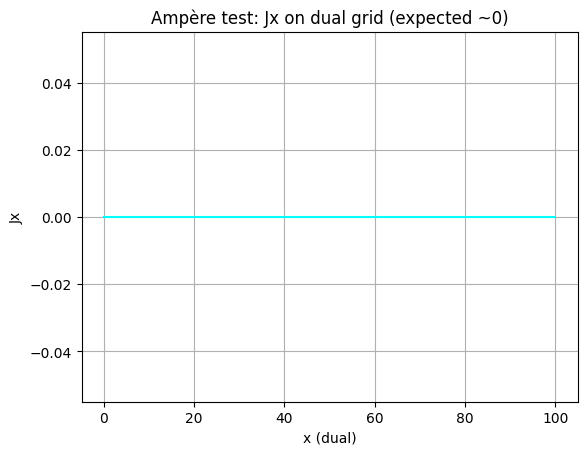

Max |Jx| = 0.0


In [6]:
# Plot J_x (should be ~0 in 1D), we plot on the dual grid

xdual_plot = xdual[1:-1]  # if len(xdual)=len(Jx)+2
plt.figure()
plt.plot(xdual_plot, Jx, color='cyan')
plt.xlabel("x (dual)")
plt.ylabel("Jx")
plt.title("Ampère test: Jx on dual grid (expected ~0)")
plt.grid(True)
plt.show()

print("Max |Jx| =", np.max(np.abs(Jx)))

## Error diagnostics 

We compute and plot the pointwise errors:

- absolute error: $e(x) = J(x) - J_{\rm exact}(x)$

This helps check where the discrepancy is largest (typically near boundaries or where the derivative stencil changes).

In [7]:
# Skip first primal point because Ampere sets it by boundary handling (no stencil for ix-1)
mask = np.ones_like(xprimal, dtype=bool)
mask[0] = False  # drop the first point

err_Jy = (Jy - Jy_exact)[mask]
err_Jz = (Jz - Jz_exact)[mask]
x_err  = xprimal[mask]

print("Max abs error Jy:", np.max(np.abs(err_Jy)))
print("Max abs error Jz:", np.max(np.abs(err_Jz)))
print("Max rel error Jy:", np.max(rel_err_Jy))
print("Max rel error Jz:", np.max(rel_err_Jz))

plt.figure()
plt.plot(x_err, err_Jy, label="Jy - Jy_exact", color = 'magenta')
plt.xlabel("x (primal)")
plt.ylabel("Error")
plt.title("Ampère test: pointwise error on Jy")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(x_err, err_Jz, label="Jz - Jz_exact", color = 'violet')
plt.xlabel("x (primal)")
plt.ylabel("Error")
plt.title("Ampère test: pointwise error on Jz")
plt.grid(True)
plt.legend()
plt.show()

Max abs error Jy: 0.0004166144221018353
Max abs error Jz: 0.00041661312431695574


NameError: name 'rel_err_Jy' is not defined